# Task 1: Regression on ZINC dataset


This notebook is adapted from the National University of Singapore CS5284 Graph Machine Learning course, the original tutorial code can be found at [here](https://github.com/xbresson/CS5284_2024/blob/main/codes/10_Graph_Transformers/code04_solution.ipynb). It mainly focus on optimizing the Graph Transformer (GT) model, and testing the model by regression task on the ZINC dataset. The ZINC dataset used here is a subset of the original one, which only contains 2,000 training samples and 200 testing samples.

> Some code snippets are generated by GPT-4o, and some text descriptions are generated by GPT-4o and o1-mini(preview).

In [ ]:
# For Google Colaboratory
import sys, os
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount("/content/drive/")
    path = "/content/drive/MyDrive/yanming_dissertation/gtv2/code/"
    os.chdir(path)
    !pwd
    !pip install dgl==1.0.0
    !pip install rdkit==2023.09.6

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/yanming_dissertation/gt_v2/code


In [2]:
# Libraries
import pickle
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import time
import networkx as nx
import sys; sys.path.insert(0, "lib/")
from lib.molecules import Dictionary, MoleculeDataset, MoleculeDGL, Molecule, compute_ncut
import os, datetime
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")
import numpy as np
import math

In [3]:
# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device= torch.device("cuda")
else:
  device= torch.device("cpu")
print(device)

2.5.1+cu124
Tesla T4
cuda


## Load Dataset

Loading data...
dataset/ZINC/
Time: 1.7527 sec
num train data : 2000
atom_dict.idx2word : ['C', 'O', 'N', 'F', 'C H1', 'S', 'Cl', 'O -', 'N H1 +', 'Br', 'N H3 +', 'N H2 +', 'N +', 'N -', 'I', 'S -', 'P', 'N H1 -']
atom_dict.word2idx : {'C': 0, 'O': 1, 'N': 2, 'F': 3, 'C H1': 4, 'S': 5, 'Cl': 6, 'O -': 7, 'N H1 +': 8, 'Br': 9, 'N H3 +': 10, 'N H2 +': 11, 'N +': 12, 'N -': 13, 'I': 14, 'S -': 15, 'P': 16, 'N H1 -': 17}
bond_dict.idx2word : ['NONE', 'SINGLE', 'DOUBLE', 'TRIPLE']
bond_dict.word2idx : {'NONE': 0, 'SINGLE': 1, 'DOUBLE': 2, 'TRIPLE': 3}
18 4
train[idx].atom_type : tensor([0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 2, 0, 5])
train[idx].atom_type_pe : tensor([ 0,  1,  2,  3,  4,  5,  6,  0,  1,  7,  2,  8,  9, 10, 11, 12,  3, 13,
        14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,  0,  4, 25,  0])
train[idx].bond_type : tensor([[0, 1, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
   

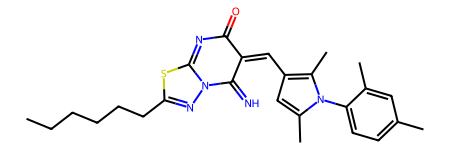

In [4]:
print("Loading data...")
start = time.time()

data_folder_pytorch = "dataset/ZINC/"
print(data_folder_pytorch)

with open(data_folder_pytorch+"atom_dict.pkl","rb") as f:
    atom_dict=pickle.load(f)
with open(data_folder_pytorch+"bond_dict.pkl","rb") as f:
    bond_dict=pickle.load(f)
with open(data_folder_pytorch+"train.pkl","rb") as f:
    train=pickle.load(f)
with open(data_folder_pytorch+"val.pkl","rb") as f:
    val=pickle.load(f)
with open(data_folder_pytorch+"test.pkl","rb") as f:
    test=pickle.load(f)

print(f"Time: {time.time() - start:.4f} sec")

print("num train data :", len(train))
print("atom_dict.idx2word :", atom_dict.idx2word)
print("atom_dict.word2idx :", atom_dict.word2idx)
print("bond_dict.idx2word :", bond_dict.idx2word)
print("bond_dict.word2idx :", bond_dict.word2idx)

num_atom_type = len(atom_dict.idx2word)
num_bond_type = len(bond_dict.idx2word)
print(num_atom_type, num_bond_type)

idx = 0
print("train[idx].atom_type :", train[idx].atom_type)
print("train[idx].atom_type_pe :", train[idx].atom_type_pe)
print("train[idx].bond_type :", train[idx].bond_type)
print("train[idx].bag_of_atoms :", train[idx].bag_of_atoms)
print("train[idx].smile: ", train[idx].smile)
print("train[idx].logP_SA", train[idx].logP_SA)
mol = Chem.MolFromSmiles(train[idx].smile)
mol

## Dataset Statistics

In [5]:
# Organize data into group of of molecules of fixed sized
# Example: train[22] is a list containing all the molecules of size 22
def group_molecules_per_size(dataset):
    mydict = {}
    for mol in dataset:
        if len(mol) not in mydict:
            mydict[len(mol)] = []
        mydict[len(mol)].append(mol)
    return mydict

test_group  = group_molecules_per_size(test)
val_group   = group_molecules_per_size(val)
train_group = group_molecules_per_size(train)

# The biggest molecule in the train set
max_mol_sz= max(list( train_group.keys()))
print("Max num atoms = ", max_mol_sz)

# Print distribution w.r.t. molecule size
def print_distribution(data):
    for nb_atom in range(max_mol_sz+1):
        try:
            print("number of molecule of size {}: \t {}".format(nb_atom, len(data[nb_atom])))
        except:
            pass

print()
# print("Train"); print_distribution(train_group)
# print("Val"); print_distribution(val_group)
print("Test"); print_distribution(test_group)

Max num atoms =  37

Test
number of molecule of size 12: 	 1
number of molecule of size 13: 	 1
number of molecule of size 14: 	 2
number of molecule of size 15: 	 5
number of molecule of size 16: 	 4
number of molecule of size 17: 	 7
number of molecule of size 18: 	 16
number of molecule of size 19: 	 7
number of molecule of size 20: 	 11
number of molecule of size 21: 	 17
number of molecule of size 22: 	 8
number of molecule of size 23: 	 14
number of molecule of size 24: 	 21
number of molecule of size 25: 	 16
number of molecule of size 26: 	 12
number of molecule of size 27: 	 21
number of molecule of size 28: 	 5
number of molecule of size 29: 	 11
number of molecule of size 30: 	 3
number of molecule of size 31: 	 7
number of molecule of size 32: 	 4
number of molecule of size 33: 	 4
number of molecule of size 34: 	 2
number of molecule of size 36: 	 1


## Generate Batches

### Implement the molecule sampler class for batch sampling of molecules

In [6]:
class MoleculeSampler:
    def __init__(self, organized_dataset, bs, shuffle=True):
        self.bs = bs
        self.num_mol =  {sz: len(list_of_mol) for sz, list_of_mol in organized_dataset.items()}
        self.counter = {sz: 0   for sz in organized_dataset}
        if shuffle:
            self.order = {sz: np.random.permutation(num)  for sz , num in self.num_mol.items()}
        else:
            self.order = {sz: np.arange(num)  for sz , num in self.num_mol.items()}

    def compute_num_batches_remaining(self):
        return {sz:  math.ceil(((self.num_mol[sz] - self.counter[sz])/self.bs))  for sz in self.num_mol}

    def choose_molecule_size(self):
        num_batches = self.compute_num_batches_remaining()
        possible_sizes = np.array(list(num_batches.keys()))
        prob = np.array(list(num_batches.values()))
        prob = prob / prob.sum()
        sz   = np.random.choice(possible_sizes, p=prob)
        return sz

    def is_empty(self):
        num_batches= self.compute_num_batches_remaining()
        return sum(num_batches.values()) == 0

    def draw_batch_of_molecules(self, sz):
        if (self.num_mol[sz] - self.counter[sz]) / self.bs >= 1.0:
            bs = self.bs
        else:
            bs = self.num_mol[sz] - (self.num_mol[sz] // self.bs) * self.bs
        indices = self.order[sz][self.counter[sz]:self.counter[sz] + bs]
        self.counter[sz] += bs
        return indices

### Extract one mini-batch

In [7]:
# extract one mini-batch
bs = 50
sampler = MoleculeSampler(train_group, bs)
print('sampler.num_mol :', sampler.num_mol)

num_batches_remaining = sampler.compute_num_batches_remaining()
print('num_batches_remaining :', num_batches_remaining)
sz = sampler.choose_molecule_size()
print('sz :', sz)
indices = sampler.draw_batch_of_molecules(sz)
print('indices :', len(indices), indices)
minibatch_node = torch.stack([train_group[sz][i].atom_type for i in indices])
print('minibatch_node :', minibatch_node.size())
minibatch_pe  = torch.stack([train_group[sz][i].atom_type_pe for i in indices])
print('minibatch_pe :', minibatch_pe.size())
minibatch_edge = torch.stack([ train_group[sz][i].bond_type for i in indices])
print('minibatch_edge :', minibatch_edge.size())
minibatch_boa = torch.stack([train_group[sz][i].bag_of_atoms for i in indices])
print('minibatch_boa :', minibatch_boa.size())

sampler.num_mol : {33: 22, 18: 89, 26: 174, 16: 51, 32: 29, 22: 159, 34: 13, 27: 135, 23: 175, 20: 145, 25: 169, 28: 85, 24: 183, 19: 107, 29: 69, 14: 24, 36: 4, 21: 152, 31: 44, 17: 61, 30: 37, 11: 4, 12: 5, 13: 17, 35: 10, 15: 30, 37: 3, 7: 1, 10: 2, 9: 1}
num_batches_remaining : {33: 1, 18: 2, 26: 4, 16: 2, 32: 1, 22: 4, 34: 1, 27: 3, 23: 4, 20: 3, 25: 4, 28: 2, 24: 4, 19: 3, 29: 2, 14: 1, 36: 1, 21: 4, 31: 1, 17: 2, 30: 1, 11: 1, 12: 1, 13: 1, 35: 1, 15: 1, 37: 1, 7: 1, 10: 1, 9: 1}
sz : 26
indices : 50 [119  55 109  31 171 141 147 173  26   9 163  12  75 159  62  99  33 122
   8 165  25 153  19  65  93  80 126  43  97  16  54 160  40  56 124 151
 125  49 105  70 140 156 130 103 138 120  47 158  67  71]
minibatch_node : torch.Size([50, 26])
minibatch_pe : torch.Size([50, 26])
minibatch_edge : torch.Size([50, 26, 26])
minibatch_boa : torch.Size([50, 18])


## Graph Tranformer Networks

In [8]:
# Global constants
num_heads = 8; d = 16 * num_heads; num_layers = 4; drop = 0.0; bs = 50
print("d, num_heads, num_layers, drop : ", d, num_heads, num_layers, drop)

# Warmup
num_mol_size = 20
num_warmup = 2 * max(num_mol_size, len(train) // bs)
print('num_warmup :', num_warmup)

# Symmetric tensor function
def sym_tensor(x):
    x = x.permute(0, 3, 1, 2)
    triu = torch.triu(x, diagonal=1).transpose(3, 2)
    mask = (triu.abs()>0).float()
    x =  x * (1 - mask) + mask * triu
    x = x.permute(0, 2, 3, 1)
    return x

d, num_heads, num_layers, drop :  128 8 4 0.0
num_warmup : 80


### Define GTv1 attention layer

In [9]:
# GT Version 1
class head_attention_v1(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.Q = nn.Linear(d, d_head)
        self.K = nn.Linear(d, d_head)
        self.E = nn.Linear(d, d_head)
        self.V = nn.Linear(d, d_head)
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
        self.drop_att = nn.Dropout(drop)
        self.Ni = nn.Linear(d, d_head)
        self.Nj = nn.Linear(d, d_head)
    def forward(self, x, e):
        Q = self.Q(x) # [bs, n, d_head]
        K = self.K(x) # [bs, n, d_head]
        V = self.V(x) # [bs, n, d_head]
        Q = Q.unsqueeze(2) # [bs, n, 1, d_head]
        K = K.unsqueeze(1) # [bs, 1, n, d_head]
        E = self.E(e) # [bs, n, n, d_head]
        Ni = self.Ni(x).unsqueeze(2) # [bs, n, 1, d_head]
        Nj = self.Nj(x).unsqueeze(1) # [bs, 1, n, d_head]
        e = Ni + Nj + E
        Att = (Q * e * K).sum(dim=3) / self.sqrt_d # [bs, n, n]
        Att = torch.softmax(Att, dim=1) # [bs, n, n]
        Att = self.drop_att(Att)
        x = Att @ V  # [bs, n, d_head]
        return x, e

### Define GTv2 attention layer

#### Self-attention and cross-attention modules

In [10]:
# GT Version 2
class attention_node_to_edge(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.Q_node = nn.Linear(d, d_head)
        self.K_edge = nn.Linear(d, d_head)
        self.V_edge = nn.Linear(d, d_head)
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
        self.drop_att = nn.Dropout(drop)
    def forward(self, x, e):
        Q_node = self.Q_node(x) # [bs, n, d_head]
        K_edge = self.K_edge(e) # [bs, n, n, d_head]
        V_edge = self.V_edge(e) # [bs, n, n, d_head]
        Q_node = Q_node.unsqueeze(2) # [bs, n, 1, d_head]
        Att = (Q_node * K_edge).sum(dim=3) / self.sqrt_d # [bs, n, n]
        Att = torch.softmax(Att, dim=2)
        Att = self.drop_att(Att)
        Att = Att.unsqueeze(-1) # [bs, n, n, 1]
        x = (Att * V_edge).sum(dim=2) # [bs, n, d_head]
        return x, e # [bs, n, d_head]


class attention_edge_to_node(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.Q_edge = nn.Linear(d, d_head)
        self.K_node = nn.Linear(d, d_head)
        self.V_node = nn.Linear(d, d_head)
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
        self.drop_att = nn.Dropout(drop)
    def forward(self, x, e):
        Q_edge = self.Q_edge(e) # [bs, n, n, d_head]
        K_node = self.K_node(x) # [bs, n, d_head]
        V_node = self.V_node(x) # [bs, n, d_head]
        K_i = K_node.unsqueeze(1).expand(-1, e.size(1), -1, -1) # [bs, n, n, d_head]
        V_i = V_node.unsqueeze(1).expand(-1, e.size(1), -1, -1) # [bs, n, n, d_head]
        K_j = K_node.unsqueeze(2).expand(-1, -1, e.size(1), -1) # [bs, n, n, d_head]
        V_j = V_node.unsqueeze(2).expand(-1, -1, e.size(1), -1) # [bs, n, n, d_head]
        Att_i = torch.exp((Q_edge * K_i).sum(dim=-1) / self.sqrt_d) # [bs, n, n]
        Att_j = torch.exp((Q_edge * K_j).sum(dim=-1) / self.sqrt_d) # [bs, n, n]
        Att_sum = Att_i + Att_j
        Att_i = self.drop_att(Att_i / Att_sum)
        Att_j = self.drop_att(Att_j / Att_sum)
        e = Att_i.unsqueeze(-1) * V_i + Att_j.unsqueeze(-1) * V_j # [bs, n, n, d_head]
        return x, e


class attention_node_to_node(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.Q = nn.Linear(d, d_head)  # For node queries
        self.K = nn.Linear(d, d_head)  # For node keys
        self.V = nn.Linear(d, d_head)  # For node values
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
        self.dropout = nn.Dropout(drop)
    def forward(self, x, e):
        Q = self.Q(x)  # [bs, n, d_head]
        K = self.K(x)  # [bs, n, d_head]
        V = self.V(x)  # [bs, n, d_head]
        Q = Q.unsqueeze(2)  # [bs, n, 1, d_head]
        K = K.unsqueeze(1)  # [bs, 1, n, d_head]
        Att = (Q * K).sum(dim=-1) / self.sqrt_d  # [bs, n, n]
        Att = torch.softmax(Att, dim=-1)  # [bs, n, n]
        Att = self.dropout(Att)
        x = Att @ V  # [bs, n, d_head]
        return x, e

#### Different types of attention heads in GTv2

1. **Weighted integration**: define a fixed weight $\alpha$ to integrate the self-attention and cross-attention results. The final output is computed as
   $$
   h_k = \alpha \cdot \text{CrossAttention}(h^{\ell}) + (1 - \alpha) \cdot \text{SelfAttention}(h^{\ell}).
   $$

In [11]:
class head_attention_v2_weighted(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.alpha = 0.5
        self.cross_att_node_to_edge = attention_node_to_edge(d, d_head)
        self.cross_att_edge_to_node = attention_edge_to_node(d, d_head)
        self.cross_att_node_to_node = attention_node_to_node(d, d_head)
    def forward(self, x, e):
        # 1) Cross-attention from nodes to edges
        x_cross, _ = self.cross_att_node_to_edge(x, e)
        # 2) Cross-attention from edges to nodes
        _, e = self.cross_att_edge_to_node(x, e)
        # 3) Self-attention on nodes
        x_self, _ = self.cross_att_node_to_node(x, e)
        x = self.alpha * x_cross + (1 - self.alpha) * x_self
        return x, e

2. **Gated integration**: instead of using a fixed weight for the combination, the model learns a dynamic gating mechanism to adjust the contributions of cross-attention and self-attention as
   $$
   g = \sigma(W_g \cdot \text{Concat} [\text{CrossAttention}(h^{\ell}), \text{SelfAttention}(h^{\ell})] + b_g)  \\
   h_k = g \odot \text{CrossAttention}(h^{\ell}) + (1 - g) \odot \text{SelfAttention}(h^{\ell}),
   $$
   where $\sigma$ is the sigmoid function, and $W_g$ and $b_g$ are learnable parameters.

In [12]:
class head_attention_v2_gated(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.cross_att_node_to_edge = attention_node_to_edge(d, d_head)
        self.cross_att_edge_to_node = attention_edge_to_node(d, d_head)
        self.cross_att_node_to_node = attention_node_to_node(d, d_head)
        self.gated_mlp = nn.Sequential(
            nn.Linear(2 * d_head, d_head),
            nn.Sigmoid(),
        )
    def forward(self, x, e):
        # 1) Cross-attention from nodes to edges
        x_cross, _ = self.cross_att_node_to_edge(x, e)
        # 2) Cross-attention from edges to nodes
        _, e = self.cross_att_edge_to_node(x, e)
        # 3) Self-attention on nodes
        x_self, _ = self.cross_att_node_to_node(x, e)
        # 4) Gated MLP
        g = self.gated_mlp(torch.cat([x_cross, x_self], dim=-1))
        x = g * x_cross + (1 - g) * x_self
        return x, e

3. **Mixed integration**: the model learns a linear combination of the cross-attention and self-attention as
   $$
   h_k = W_m \cdot \text{Concat} [\text{CrossAttention}(h^{\ell}), \text{SelfAttention}(h^{\ell})] + b_m,
   $$
   where $W_m$ and $b_m$ are learnable parameters.

In [13]:
class head_attention_v2_mixed(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.cross_att_node_to_edge = attention_node_to_edge(d, d_head)
        self.cross_att_edge_to_node = attention_edge_to_node(d, d_head)
        self.cross_att_node_to_node = attention_node_to_node(d, d_head)
        self.mix_ll = nn.Linear(2 * d_head, d_head, bias=True)
    def forward(self, x, e):
        # 1) Cross-attention from nodes to edges
        x_cross, _ = self.cross_att_node_to_edge(x, e)
        # 2) Cross-attention from edges to nodes
        _, e = self.cross_att_edge_to_node(x, e)
        # 3) Self-attention on nodes
        x_self, _ = self.cross_att_node_to_node(x, e)
        # 4) Mixing
        x = self.mix_ll(torch.cat([x_cross, x_self], dim=-1))
        return x, e

4. **FiLM integration**: the model leverages a FiLM layer to modulate the cross-attention and self-attention results as
   $$
   h_k = W_1 \cdot \text{SelfAttention}(h^{\ell}) + \lbrack W_2 \cdot \text{SelfAttention}(h^{\ell}) \rbrack \odot \text{CrossAttention}(h^{\ell}) + \text{CrossAttention}(h^{\ell}),
   $$
   where $W_1$ and $W_2$ are learnable weight matrices.

In [14]:
class head_attention_v2_film(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.cross_att_node_to_edge = attention_node_to_edge(d, d_head)
        self.cross_att_edge_to_node = attention_edge_to_node(d, d_head)
        self.cross_att_node_to_node = attention_node_to_node(d, d_head)
        self.weight_1 = nn.Linear(d_head, d_head)
        self.weight_2 = nn.Linear(d_head, d_head)
    def forward(self, x, e):
        # 1) Cross-attention from nodes to edges
        x_cross, _ = self.cross_att_node_to_edge(x, e)
        # 2) Cross-attention from edges to nodes
        _, e = self.cross_att_edge_to_node(x, e)
        # 3) Self-attention on nodes
        x_self, _ = self.cross_att_node_to_node(x, e)
        # 4) FiLM layer
        x = self.weight_1(x_self) + self.weight_2(x_self) * x_cross + x_cross
        return x, e

### Define the GT network

In [ ]:
class MHA(nn.Module):
    def __init__(self, d, num_heads):
        super().__init__()
        d_head = d // num_heads

        # GTv1
        # self.heads = nn.ModuleList([head_attention_v1(d, d_head) for _ in range(num_heads)])

        # GTv2 (weighted)
        # self.heads = nn.ModuleList([head_attention_v2_weighted(d, d_head) for _ in range(num_heads)])

        # GTv2 (gated)
        # self.heads = nn.ModuleList([head_attention_v2_gated(d, d_head) for _ in range(num_heads)])

        # GTv2 (mixed)
        # self.heads = nn.ModuleList([head_attention_v2_mixed(d, d_head) for _ in range(num_heads)])

        # GTv2 (FiLM)
        self.heads = nn.ModuleList([head_attention_v2_film(d, d_head) for _ in range(num_heads)])

        self.WOx = nn.Linear(d, d)
        self.WOe = nn.Linear(d, d)
        self.drop_x = nn.Dropout(drop)
        self.drop_e = nn.Dropout(drop)
    def forward(self, x, e):
        x_MHA = []
        e_MHA = []
        for head in self.heads:
            x_HA, e_HA = head(x,e)
            x_MHA.append(x_HA)
            e_MHA.append(e_HA)
        x = self.WOx(torch.cat(x_MHA, dim=2)) # [bs, n, d]
        x = self.drop_x(x)
        e = self.WOe(torch.cat(e_MHA, dim=3)) # [bs, n, n, d]
        e = self.drop_e(e)
        return x, e

class BlockGT(nn.Module):
    def __init__(self, d, num_heads):
        super().__init__()
        self.LNx = nn.LayerNorm(d)
        self.LNx2 = nn.LayerNorm(d)
        self.MLPx = nn.Sequential(nn.Linear(d, 4*d), nn.ReLU(), nn.Linear(4*d, d))
        self.MHA = MHA(d, num_heads)
        self.drop_x_mlp = nn.Dropout(drop)
        self.LNe = nn.LayerNorm(d)
        self.LNe2 = nn.LayerNorm(d)
        self.MLPe = nn.Sequential(nn.Linear(d, 4*d), nn.ReLU(), nn.Linear(4*d, d))
        self.drop_x_mlp = nn.Dropout(drop)
        self.drop_e_mlp = nn.Dropout(drop)
    def forward(self, x, e):
        x = self.LNx(x)
        e = self.LNe(e)
        x_MHA, e_MHA = self.MHA(x, e) # [bs, n, d], [bs, n, n, d]
        x = x + x_MHA # [bs, n, d]
        x = x + self.MLPx(self.LNx2(x)) # [bs, n, d]
        x = self.drop_x_mlp(x)
        e = e + e_MHA
        e = e + self.MLPe(self.LNe2(e)) # [bs, n, n, d]
        e = self.drop_e_mlp(e)
        return x, e

class GT(nn.Module):
    def __init__(self):
        super().__init__()
        self.atom_emb = nn.Embedding(num_atom_type, d)
        self.bond_emb = nn.Embedding(num_bond_type, d)
        num_layers_encoder = 4
        self.BlockGT_encoder_layers = nn.ModuleList( [BlockGT(d, num_heads) for _ in range(num_layers_encoder)] )
        self.ln_x_final = nn.LayerNorm(d)
        self.linear_x_final = nn.Linear(d, 1, bias=True)
        self.drop_x_emb = nn.Dropout(drop)
        self.drop_e_emb = nn.Dropout(drop)
    def forward(self, x, e):
        x = self.atom_emb(x) # [bs, n, d]
        e = self.bond_emb(e) # [bs, n, n, d]
        e = sym_tensor(e) # [bs, n, n, d]
        x = self.drop_x_emb(x)
        e = self.drop_e_emb(e)
        for gt_layer in self.BlockGT_encoder_layers:
            x, e = gt_layer(x, e)  # [bs, n, d], [bs, n, n, d]
            e = sym_tensor(e)
        mol_token = x.mean(1) # [bs, d]
        x = self.ln_x_final(mol_token)
        x = self.linear_x_final(x)
        return x

### Instantiate and test the model

In [16]:
net = GT()
net = net.to(device)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)

# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True)

bs = 50
sampler = MoleculeSampler(train_group, bs)
print('sampler.num_mol :',sampler.num_mol)
num_batches_remaining = sampler.compute_num_batches_remaining()
print('num_batches_remaining :',num_batches_remaining)
sz = sampler.choose_molecule_size()
print('sz :',sz)
indices = sampler.draw_batch_of_molecules(sz)
print('indices :',len(indices),indices)
batch_x0 = minibatch_node = torch.stack( [ train_group[sz][i].atom_type for i in indices] ).long().to(device) # [bs, n]
print('minibatch_node :',minibatch_node.size())
batch_e0 = minibatch_edge = torch.stack( [ train_group[sz][i].bond_type for i in indices] ).long().to(device) # [bs, n, n]
print('minibatch_edge :',minibatch_edge.size())
batch_target = torch.stack( [ train_group[sz][i].logP_SA_cycle_normalized for i in indices] ).float().to(device) # [bs, 1]
print('batch_target :',batch_target.size())

batch_x_pred = net(batch_x0, batch_e0) # [bs, 1]
print('batch_x_pred',batch_x_pred.size())

loss = nn.L1Loss()(batch_x_pred, batch_target)
optimizer.zero_grad()
loss.backward()
optimizer.step()

del net
torch.cuda.empty_cache()

Number of parameters: 1804929 (1.80 million)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


sampler.num_mol : {33: 22, 18: 89, 26: 174, 16: 51, 32: 29, 22: 159, 34: 13, 27: 135, 23: 175, 20: 145, 25: 169, 28: 85, 24: 183, 19: 107, 29: 69, 14: 24, 36: 4, 21: 152, 31: 44, 17: 61, 30: 37, 11: 4, 12: 5, 13: 17, 35: 10, 15: 30, 37: 3, 7: 1, 10: 2, 9: 1}
num_batches_remaining : {33: 1, 18: 2, 26: 4, 16: 2, 32: 1, 22: 4, 34: 1, 27: 3, 23: 4, 20: 3, 25: 4, 28: 2, 24: 4, 19: 3, 29: 2, 14: 1, 36: 1, 21: 4, 31: 1, 17: 2, 30: 1, 11: 1, 12: 1, 13: 1, 35: 1, 15: 1, 37: 1, 7: 1, 10: 1, 9: 1}
sz : 25
indices : 50 [ 70 165  61 109  83 152 140  59  53 108 112  82   1   8  21 137 154  95
 151  52  38  24  92 127  97  58  87 142 163 131 147 143 119 129 132   3
  28  69 106 120 159  11 167  77 148   6  85  63  19 141]
minibatch_node : torch.Size([50, 25])
minibatch_edge : torch.Size([50, 25, 25])
batch_target : torch.Size([50, 1])
batch_x_pred torch.Size([50, 1])


## Train And Evaluate The Model

In [17]:
# Random seed
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

# Training loop
net = GT()
net = net.to(device)

# Optimizer
init_lr = 0.0001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda t: min((t+1)/num_warmup, 1.0) ) # warmup scheduler
scheduler_tracker = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True) # tracker scheduler

num_warmup_batch = 0

# Number of mini-batches per epoch
nb_epochs = 50

lossMAE = nn.L1Loss()

print("num batch(before scheduler_tracker), num epoch(before scheduler_tracker), num_warmup_batch(current): ", \
      num_warmup, num_warmup//(len(train)//bs), num_warmup_batch)

total_loss = moving_loss = -1
list_loss = []
start=time.time()
for epoch in range(nb_epochs):
    running_loss = 0.0
    num_batches = 0
    num_data = 0
    net.train()

    bs = 50
    sampler = MoleculeSampler(train_group, bs)
    while(not sampler.is_empty()):
        num_batches_remaining = sampler.compute_num_batches_remaining()
        sz = sampler.choose_molecule_size()
        indices = sampler.draw_batch_of_molecules(sz)
        bs2 = len(indices)
        batch_x0 = minibatch_node = torch.stack( [ train_group[sz][i].atom_type for i in indices] ).long().to(device) # [bs, n]
        batch_e0 = minibatch_edge = torch.stack( [ train_group[sz][i].bond_type for i in indices] ).long().to(device) # [bs, n, n]
        batch_target = torch.stack( [ train_group[sz][i].logP_SA_cycle_normalized for i in indices] ).float().to(device) # [bs, 1]
        batch_x_pred = net(batch_x0, batch_e0) # [bs, 1]
        loss = lossMAE(batch_x_pred, batch_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if num_warmup_batch < num_warmup:
            scheduler_warmup.step() # warmup scheduler
        num_warmup_batch += 1

        # Compute stats
        running_loss += bs2 * loss.detach().item()
        num_batches += 1
        num_data += bs2

    # Test set
    bs = 50
    sampler = MoleculeSampler(test_group, bs)
    running_test_loss = 0
    num_test_data = 0
    with torch.no_grad():
        while(not sampler.is_empty()):
            num_batches_remaining = sampler.compute_num_batches_remaining()
            sz = sampler.choose_molecule_size()
            indices = sampler.draw_batch_of_molecules(sz)
            bs2 = len(indices)
            batch_x0 = minibatch_node = torch.stack( [ test_group[sz][i].atom_type for i in indices] ).long().to(device) # [bs, n]
            batch_e0 = minibatch_edge = torch.stack( [ test_group[sz][i].bond_type for i in indices] ).long().to(device) # [bs, n, n]
            batch_target = torch.stack( [ test_group[sz][i].logP_SA_cycle_normalized for i in indices] ).float().to(device) # [bs, 1]
            batch_x_pred = net(batch_x0, batch_e0) # [bs, 1]
            running_test_loss += bs2 * lossMAE(batch_x_pred, batch_target).detach().item()
            num_test_data += bs2

    # Average stats and display
    mean_train_loss = running_loss/num_data
    mean_test_loss = running_test_loss/num_test_data
    if num_warmup_batch >= num_warmup:
        scheduler_tracker.step(mean_train_loss) # tracker scheduler defined w.r.t. loss value
        num_warmup_batch += 1
    elapsed = (time.time()-start)/60
    if not epoch%1:
        line = 'epoch= ' + str(epoch) + '\t time= ' + str(elapsed)[:6] + ' min' + '\t lr= ' + \
        '{:.7f}'.format(optimizer.param_groups[0]['lr']) + '\t train_loss= ' + str(mean_train_loss)[:6] + \
        '\t test_loss= ' + str(mean_test_loss)[:6]
        print(line)

    # Check lr value
    if optimizer.param_groups[0]['lr'] < 10**-6:
      print("\n lr is equal to min lr -- training stopped\n")
      break

del net
torch.cuda.empty_cache()

num batch(before scheduler_tracker), num epoch(before scheduler_tracker), num_warmup_batch(current):  80 2 0
epoch= 0	 time= 0.3241 min	 lr= 0.0000750	 train_loss= 1.6050	 test_loss= 1.3146
epoch= 1	 time= 0.4966 min	 lr= 0.0001000	 train_loss= 1.4526	 test_loss= 1.1693
epoch= 2	 time= 0.6821 min	 lr= 0.0001000	 train_loss= 1.1256	 test_loss= 0.8656
epoch= 3	 time= 0.8646 min	 lr= 0.0001000	 train_loss= 0.9132	 test_loss= 0.8454
epoch= 4	 time= 1.0238 min	 lr= 0.0001000	 train_loss= 0.8365	 test_loss= 0.6711
epoch= 5	 time= 1.2001 min	 lr= 0.0001000	 train_loss= 0.7817	 test_loss= 0.6684
epoch= 6	 time= 1.3808 min	 lr= 0.0001000	 train_loss= 0.7634	 test_loss= 0.6243
epoch= 7	 time= 1.5576 min	 lr= 0.0001000	 train_loss= 0.7437	 test_loss= 0.6147
epoch= 8	 time= 1.7126 min	 lr= 0.0001000	 train_loss= 0.7165	 test_loss= 0.6075
epoch= 9	 time= 1.9122 min	 lr= 0.0001000	 train_loss= 0.6966	 test_loss= 0.6333
epoch= 10	 time= 2.0914 min	 lr= 0.0001000	 train_loss= 0.6859	 test_loss= 0.5856

## Performance Comparison

Training was conducted over 50 epochs on a small subset of the ZINC dataset (2,000 training samples and 200 testing samples) with a fixed random seed. The results presented are the mean loss (and standard deviation) from the last 10 epochs.


|             Network             | Train Loss on ZINC | Test Loss on ZINC  | Time (min) |
| :-----------------------------: | :----------------: | :----------------: | :--------: |
|              GTv1              |   0.6090(0.0067)   |   0.5624(0.0416)   |   4.7717   |
| GTv2 (Weighted, $\alpha$=0.25) |   0.5972(0.0068)   |   0.5343(0.0276)   |   8.0485   |
| GTv2 (Weighted, $\alpha$=0.5) |   0.5950(0.0089)   |   0.5294(0.0429)   |   8.1099   |
| GTv2 (Weighted, $\alpha$=0.75) |   0.5945(0.0053)   |   0.5300(0.0399)   |   8.2462   |
|          GTv2 (Gated)          |   0.5907(0.0079)   |   0.5146(0.0285)   |   9.0665   |
|          GTv2 (Mixed)          |   0.5877(0.0087)   |   0.5021(0.0363)   |   8.4175   |
|          GTv2 (FiLM)          | **0.5818**(0.0078) | **0.4995**(0.0240) |   8.6810   |

## References

1. [Vijay Prakash Dwivedi and Xavier Bresson. "A generalization of transformer networks to graphs." *arXiv preprint arXiv:2012.09699* (2020).](https://arxiv.org/abs/2012.09699)

2. [Ethan Perez, Florian Strub, Harm de Vries, Vincent Dumoulin and Aaron Courville. "Film: Visual reasoning with a general conditioning layer." In Proceedings of the AAAI conference on artificial intelligence, vol. 32, no. 1. 2018.](https://ojs.aaai.org/index.php/AAAI/article/view/11671)